In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

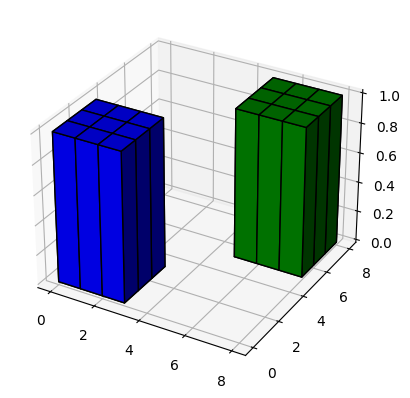

In [5]:
# prepare some coordinates
x, y, z = np.indices((8, 8, 1))

# draw cuboids in the top left and bottom right corners, and a link between
# them
cube1 = (x < 3) & (y < 3) & (z < 1)
cube2 = (x >= 5) & (y >= 5) & (z <1)
#link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxelarray = cube1 | cube2 #| link

# set the colors of each object
colors = np.empty(voxelarray.shape, dtype=object)
#colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray, facecolors=colors, edgecolor='k')

plt.show()

In [23]:
#refer to cat pieces by colours. try not to forget em. if in doubt, ROY G BIV lightest hue to darkest

#lets exclude the third dimension to start with because that shit is hard and just encode these as the minimal size 
#binary matrix that can surround a given piece.
#generate containing array of 1, then remove gaps in rectangle
#sike, doing it as squares because it makes matrix transformations/uniqueness checks work better.

#let's start this all in two dimensions, which is probably gonna be a pain later, but should make this a lot easier.
#also, going to store these in a dictionary for indicing/iteration purposes

cat_states=dict()

white=np.full((3,3), "W", dtype=str)
white[0] = ""
white[1][1:] = ""
cat_states['white']=white

pink=np.full((3,3),"P", dtype=str)
pink[0][1:] = ""
pink[2][1]=""
cat_states['pink']=pink

red=np.full((4,4),"R", dtype=str)
red[0]=""
red[1][1:] = ""
red[3][1:3]=""
cat_states['red']=red

yellow=np.full((3,3),"Y", dtype=str)
yellow[0][1:] = ""
cat_states['yellow']=yellow

mint=np.full((3,3), "M", dtype=str)
mint[0][0] = ""
mint[0][2] =""
mint[1][0] = ""
cat_states['mint']=mint

green=np.full((4,4),"G", dtype=str)
green[0][0:2] = ""
green[1][1:3] = ""
green[3][1:3] = ""
cat_states['green']=green

arctic=np.full((4,4), "A", dtype=str)
arctic[0]=""
arctic[1][0:3]=""
cat_states['arctic']=arctic

sky=np.full((2,2), "S", dtype=str)
sky[0]=""
cat_states['sky']=sky

teal=np.full((2,2), "T", dtype=str)
teal[0][1]=""
cat_states['teal']=teal

indigo=np.full((2,2), "I", dtype=str)
cat_states['indigo']=indigo

violet=np.full((3,3), "V", dtype=str)
violet[0]=""
cat_states['violet']=violet

black=np.full((3,3), "B", dtype=str)
black[0][1]=0
cat_states['black']=black


In [25]:
def _generate_rotations(cat: np.array)-> np.array:
    """Generates four rotation states of cat piece from initial state.

    Args:
        cat (np.array): Numpy array representing cat shape

    Returns:
        list[np.array]: Rotation states of of shape
    """
    states=[cat]
    for i in range(3):
        #rotate clockwise and add to state list
        cat=np.rot90(cat)
        states.append(cat)
    #remove any duplicates.
    states=np.unique(states, axis=0)
    return states

def _generate_states(cat: np.array)-> np.array:
    """Generates up to 8 rotation states of cats -- rotations, flip then rotations, then removes any duplicates.

    Args:
        cat (np.array): Numpy array representing cat shape.

    Returns:
        np.array: All orientations of shape induced by rotation and flip
    """
    
    #get rotation states
    states=_generate_rotations(cat)
    #get flip states
    f_states= _generate_rotations(np.fliplr(cat))

    #concat and remove duplicates
    unique_states=np.unique(np.vstack([states, f_states]), axis=0)
    return unique_states


In [26]:
#dictionary of all shape states

for key, val in cat_states.items():
    cat_states[key]= _generate_states(val)

In [27]:
cat_states['white']

array([[['', '', ''],
        ['', '', 'W'],
        ['W', 'W', 'W']],

       [['', '', ''],
        ['W', '', ''],
        ['W', 'W', 'W']],

       [['', '', 'W'],
        ['', '', 'W'],
        ['', 'W', 'W']],

       [['', 'W', 'W'],
        ['', '', 'W'],
        ['', '', 'W']],

       [['W', '', ''],
        ['W', '', ''],
        ['W', 'W', '']],

       [['W', 'W', ''],
        ['W', '', ''],
        ['W', '', '']],

       [['W', 'W', 'W'],
        ['', '', 'W'],
        ['', '', '']],

       [['W', 'W', 'W'],
        ['W', '', ''],
        ['', '', '']]], dtype='<U1')

In [12]:
bool("anything")

True

In [79]:
#awkward part: these arrays might have a 0 row or column because they're squares to keep array dimensions consistent across rotations.
#we could take these out and make them lists of different dimensioned arrays.....but i don't feel like figuring that out right now
#so instead, for a puzzle on an m x n grid, we're going to initiate an (m+2) x (n+2) grid where the outside rectangle will be a fixed border.

array([1])

In [54]:
#lets generate sets of all possible rotations and flips of each of these.

array([[1, 0, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [34]:
white

array([[1, 0, 0],
       [1, 1, 1]])

In [23]:
#generate 5x5x1 grid
x, y, z = np.indices((5, 5, 1))

In [18]:
row, col = np.indices((2, 3))

In [22]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])